In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hla_mel = pd.read_csv("./HLA_Mel.csv")
hla_mel = hla_mel[hla_mel['Experiment'].apply(lambda x: x.endswith("HLA-I"))]


In [3]:
naming_map = {
    hla_mel.iloc[row]['Raw file'] : hla_mel.iloc[row]['Experiment']
    for row in range(len(hla_mel))
}

In [4]:
prosit_peptides = pd.read_csv(
    "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/forPride/rescoring_for_paper_2/percolator/prosit_target.peptides", sep='\t')
# ft_peptides = pd.read_csv(
#     "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/percolator_hdf5/prosit_target.peptides", sep='\t')
ft_peptides = pd.read_csv(
    "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/percolator_hdf5_0.01/prosit_target.peptides", sep='\t')

# prosit_peptides = pd.read_csv(
#     "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/percolator/prosit_hcd_finetune/no_finetuned_all/prosit_best_target.psms", sep='\t')
# ft_peptides = pd.read_csv(
#     "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/percolator/prosit_hcd_finetune/finetuned_twofold/prosit_best_target.psms", sep='\t')


In [6]:
print((prosit_peptides['q-value'] < 0.01).sum())
print((ft_peptides['q-value'] < 0.01).sum())


180112
183609


In [6]:
def read_mel(df, threshold=0.01):
    from collections import defaultdict
    df_index = df.set_index("PSMId")
    all_mels = defaultdict(list)
    for rawname, melname in naming_map.items():
        target = df_index.filter(like=rawname, axis=0)
        f_p_petides = target[target['q-value'] < threshold]['peptide'].apply(
            lambda x: x.strip("_").strip(".")).unique()
        all_mels[melname].extend(f_p_petides)
    for name in all_mels.keys():
        all_mels[name] = set(all_mels[name])
    return all_mels


In [10]:
threshold = 0.001
prosit_mels = read_mel(prosit_peptides, threshold=threshold)
ft_mels = read_mel(ft_peptides, threshold=threshold)

all_lsg = []
for melname in ft_mels.keys():
    p_p = prosit_mels[melname]
    f_p = ft_mels[melname]
    lost = (p_p - f_p)
    share = p_p.intersection(f_p)
    gain = (f_p - p_p)
    all_lsg.append((melname, (len(lost), len(share), len(gain))))

In [11]:
def plot_alleles_lsg(all_lsg):
    all_lsg = sorted(all_lsg, key=lambda x: x[1][1] + x[1][2])
    c_loss = 'orange'
    c_shared = 'darkslateblue'
    c_gain = 'green'
    linewidth = 0.5
    barwidth = 0.9
    fig, ax = plt.subplots(figsize=(9, 6), dpi=200)

    alleles = [x[0].split("_")[0] for x in all_lsg]
    losses = [-x[1][0] for x in all_lsg]
    shares = [x[1][1] for x in all_lsg]
    gains = [x[1][2] for x in all_lsg]
    x_ticks = list(range(len(alleles)))
    p1 = ax.bar(alleles, losses, barwidth, label="Loss",
                color=c_loss, linewidth=linewidth, edgecolor='black')
    p2 = ax.bar(alleles, shares, barwidth, label="Shared",
                color=c_shared, linewidth=linewidth, edgecolor='black')
    p3 = ax.bar(alleles, gains, barwidth, label="Gain", bottom=shares,
                color=c_gain, linewidth=linewidth, edgecolor='black')
    for i, allele in enumerate(alleles):
        ax.text(i-0.2, 25000, str(gains[i]), rotation=90, va='center')
        ax.text(i-0.2, 10000, str(shares[i]), rotation=90, va='center')
        ax.text(i - 0.2, -3000, str(abs(losses[i])), rotation=90, va='center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # ax.axes.get_xaxis().set_visible(False)
    return fig, ax


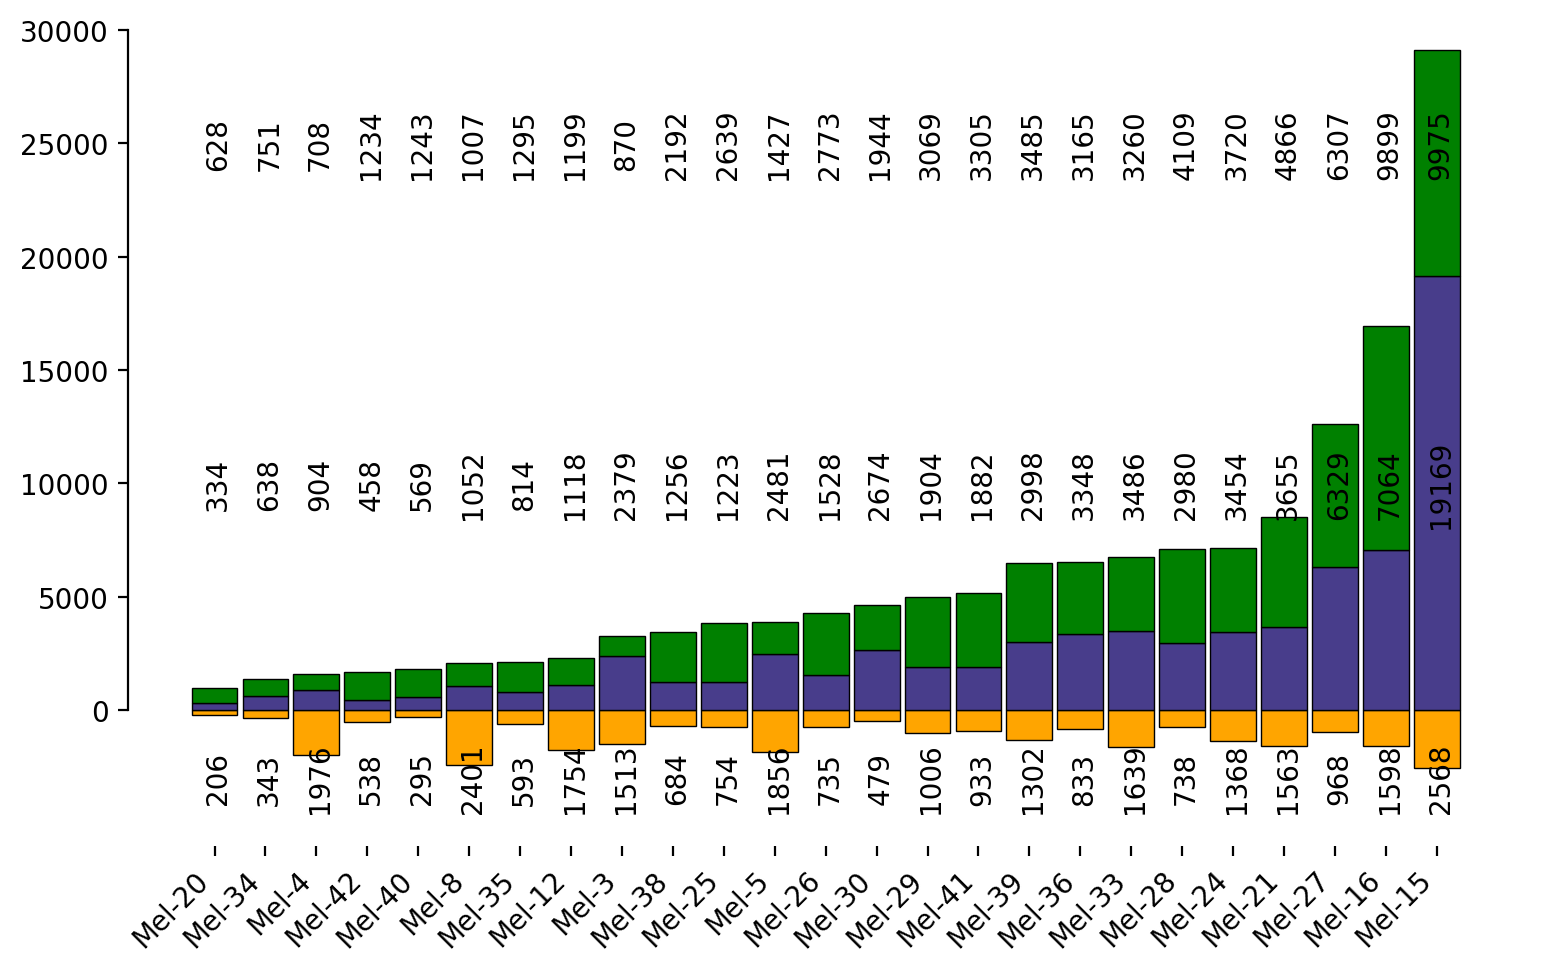

In [12]:
fig, ax = plot_alleles_lsg(all_lsg)
ax.set_ylim([-6000, 30000])
ax.set_yticks([i*5000 for i in range(7)])
ax.spines['left'].set_bounds(0, 30000)
fig.autofmt_xdate(rotation=45)
